<a href="https://colab.research.google.com/github/Fabchirajoul/Transformer_MLM_AND_BINARY_CLASSIFICATION/blob/main/MLM_WAYNE_HUGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install accelerate -U

In [2]:
# pip install transformers

In [3]:
# pip install datasets

In [4]:
from google.colab import files

# Upload an image file
uploaded_workflow = files.upload()

Saving workflow.JPG to workflow (3).JPG


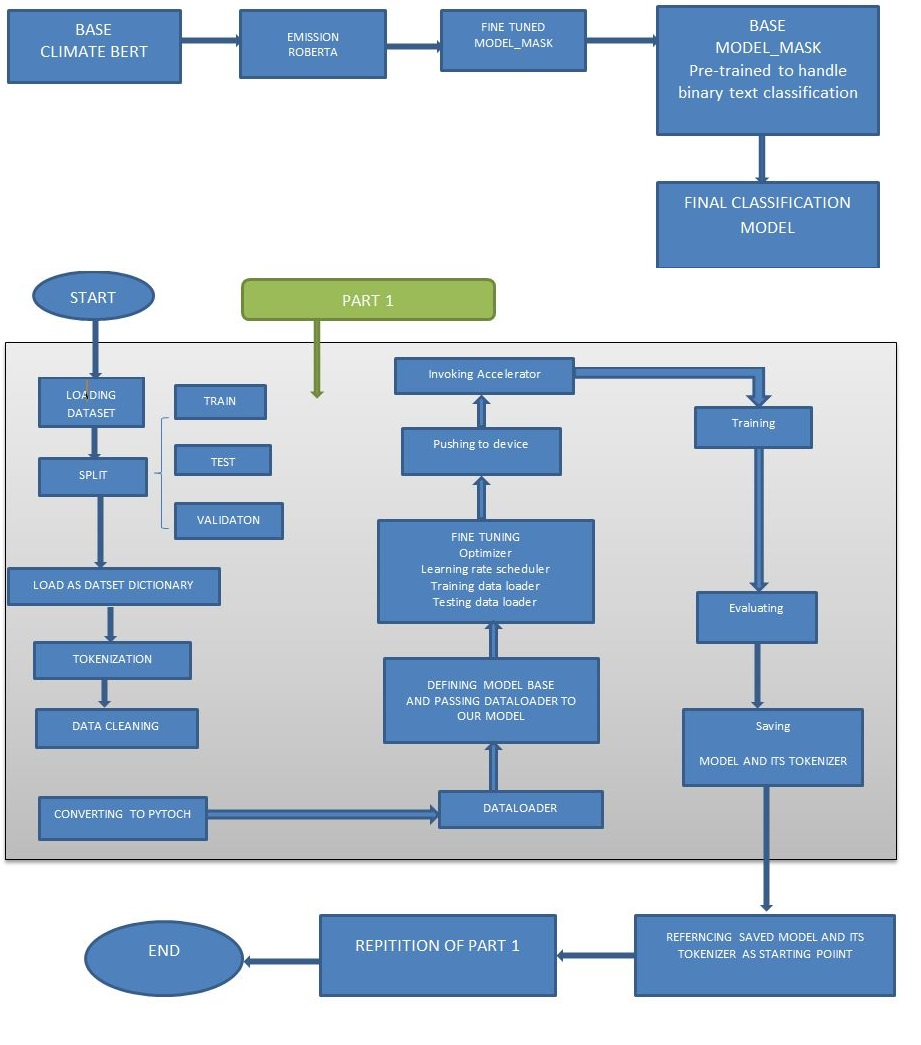

In [5]:
# Get the file name
workflow = list(uploaded_workflow.keys())[0]

# Display the uploaded image
from IPython.display import Image
Image(workflow)

# First we need to create a function that will randomly divide the single data file into training, testing and validation

In [6]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/testing_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/training_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/validation_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

## We now have our seperate datafiles for training, testing and validation

In [7]:
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import  pandas as pd
from transformers import DataCollatorWithPadding

import random
import torch
import math

data_files = {"train": "/content/training_dataset.csv",
              "validation": "/content/validation_dataset.csv",
              "test": "/content/testing_dataset.csv"
              }
df_Mask = load_dataset("csv", data_files=data_files)
df_Mask

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text'],
        num_rows: 756
    })
})

# Viewing the dictionary to see that they are actually what we want

In [8]:
print("================================================================================")
print("Training Data")
print(df_Mask['train'][0])
print("================================================================================")
print("Testing Data")
print(df_Mask['test'][0])
print("================================================================================")
print("Validation Data")
print(df_Mask['validation'][0])

Training Data
{'text': "In 2020, Indra fixed an ambitious long-term target, which is consistent with reductions required to keep warming to 1.5°C (SBTi). This target is reaching zero emissions derived from energy consumption in 2040.In 2020, Indra's carbon footprint decreased due to COVID-19 pandemic impact. In 2020, most of workplaces of Indra were closed because of health reasons and our employees were working remotely. Therefore, the significant reduction was produced mainly by external and uncontrollable facts. However, this situation has accelerated the implementation of certain policies of the company: nowadays several units of the company (e.g. Human Resources or Finances) are analysing more ambitious scenarios of remote work; and a more challenging travel policy to reduce both travel costs and emissions from business travels has also been developedAdditionally, Indra has a plan to renovate its facilities in order to improve its energy efficiency and reaching this target in 2040

In [9]:
df_Mask_test = df_Mask["test"]
df_Mask_test[0]


{'text': 'Aim was to achieve 100% emission neutral energy for offices as well as datacenters operated by comdivision or our suppliers.'}

In [10]:
df_Mask['train'].features

{'text': Value(dtype='string', id=None)}

In [11]:
df_Mask.keys()

dict_keys(['train', 'validation', 'test'])

TOKENIZATION

In [12]:
checkpoint = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



def tokenize_function(df_Mask):
    return tokenizer(df_Mask["text"], df_Mask['text'], df_Mask['text'], truncation=True, return_tensors='pt', padding="max_length")

tokenized_datasets = df_Mask.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 756
    })
})

In [13]:
tokenized_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [14]:
tokenized_datasets.column_names

{'train': ['text', 'input_ids', 'attention_mask', 'labels'],
 'validation': ['text', 'input_ids', 'attention_mask', 'labels'],
 'test': ['text', 'input_ids', 'attention_mask', 'labels']}

# Removing columns which the machine will not understand

In [15]:
# Machine does not understand categorical data i.e. text so we need to remove it


columns_to_remove = ['text']

# Remove the specified columns from each split

for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].remove_columns(columns_to_remove)



tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Setting the dataframe to a pytoch dataframe

In [16]:
tokenized_datasets.set_format("torch")

In [17]:
tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Data Loader

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

# To quickly check there is no mistake in the data processing

In [19]:
# Assuming you have train_dataloader, eval_dataloader, and test_dataloader

dataloaders = {
    'Training': train_dataloader,
    'Evaluation': eval_dataloader,
    'Testing': test_dataloader
}

for split, dataloader in dataloaders.items():
    print(f"\nThe Shape of the  {split} dataloader:")
    for batch in dataloader:
        shapes = {k: v.shape for k, v in batch.items()}
        print(shapes)
        break

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



The Shape of the  Training dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Evaluation dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Testing dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}


# Passing the training batch to our model

In [20]:
# lastly calling the our pretrained model and passing the climatebert model to the pretrained model from hugging face
model_Mask = RobertaForMaskedLM.from_pretrained(checkpoint)

outputs = model_Mask(**batch)

print(outputs.loss, outputs.logits.shape)

tensor(19.1380, grad_fn=<NllLossBackward0>) torch.Size([8, 512, 50500])


In [21]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Learning Rate Scheduler

In [22]:
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

331


# Defining and Pushing the model to our Device

In [23]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_Mask.to(device)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_Mask.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cpu
Our Training Model architecture is: 

 RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelf

# Fine Tuning

In [24]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)

# Making Use of an Accelerator

In [25]:
from accelerate import Accelerator

accelerator = Accelerator()


train_dataloader, eval_dataloader, model_Mask, optimizer= accelerator.prepare(
    train_dataloader,
    eval_dataloader,
    model_Mask,
    optimizer
    )

# Training

In [26]:
# from tqdm.auto import tqdm


# # function to train the model
# def train(
#     model=model_Mask,
#     train_dataloader=train_dataloader,
#     optimizer=optimizer,
#     # cross_entropy=cross_entropy,
#     device=device,
#     eval_dataset=eval_dataloader
# ):

#   model_Mask.train()

# progress_bar = tqdm(range(num_training_steps))

# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         outputs = model_Mask(**batch)
#         loss = outputs.loss
#         accelerator.backward(loss)

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

# Evaluaing

In [27]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Set the model to evaluation mode
# model_Mask.eval()

# # Lists to store predictions and labels
# all_predictions = []
# all_labels = []

# # Iterate through the evaluation dataloader
# for batch in eval_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model_Mask(**batch)

#     logits = outputs.logits
#     predictions = torch.argmax(logits, dim=-1).cpu().numpy()
#     labels = batch["labels"].cpu().numpy()

#     all_predictions.extend(predictions.flatten())
#     all_labels.extend(labels.flatten())

# # Calculate accuracy
# accuracy = accuracy_score(all_labels, all_predictions)

# # Calculate precision, recall, F1 score, and support
# precision, recall, f1_score, support = precision_recall_fscore_support(
#     all_labels, all_predictions, average="weighted", zero_division=1
# )

# # Print the evaluation metrics
# print(f"Accuracy: {accuracy:.3f}")
# print(f"Precision: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1 Score: {f1_score:.3f}")
# print(f"Support: {support}")


In [28]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# # Visualize the confusion matrix using seaborn heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


# Saving the model

In [29]:
torch.save(model_Mask.state_dict(), 'model_mask_learning_model.pt')

# PUSHING TO HUGGING FACE REPO

In [30]:
from huggingface_hub import notebook_login

notebook_login()

In [31]:
from huggingface_hub import Repository

repo = Repository("<path_to_dummy_folder>", clone_from="https://huggingface.co/Fabchi/first")




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/<path_to_dummy_folder> is already a clone of https://huggingface.co/Fabchi/first. Make sure you pull the latest changes with `repo.git_pull()`.


# THIS SECTION REQUIRES THE USE OF THE MODEL_MASK FOR A BINARY TEXT CLASSIFICATION TASK ON A DIFFERENT DATASET

# SPLITTING OUR CUSTOM DATASET INTO TRAINING, TESTING AND VALIDATION

In [32]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/testing_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/training_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/validation_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

# LOADING AND COMBINING OUR DATASET AS A DICTIONAARY

In [33]:
data_files = {"train": "/content/training_dataset_classification.csv",
              "validation": "/content/validation_dataset_classification.csv",
              "test": "/content/testing_dataset_classification.csv"
              }
df_classification = load_dataset("csv", data_files=data_files)
df_classification

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 79
    })
})

# LET US VIEW WHAT WE HAVE SPLITTED

In [34]:
print("================================================================================")
print("Training Data for classification")
print(df_classification['train'][1])
print("================================================================================")
print("Testing Data for classification")
print(df_classification['test'][2])
print("================================================================================")
print("Validation Data for classification")
print(df_classification['validation'][3])

Training Data for classification
{'text': 'The majority of the CapEx spend in the first half has primarily been in the area of adding new servers to add capacity into our existing PoPs.', 'label': 0}
Testing Data for classification
{'text': 'Refers to sold-product use-phase emissions, which cover 80% of our total Scope 3 emissions. All emissions (100%) of the sold-product use-phase are covered. This target was submitted in 2017 and approved by SBTi in 2019.It was part of our original 2°C target. It was kept when improving  to 1.5°C targets. The target itself may not be aligned with neither new 2°C nor 1.5°C definitions. However, it has to counteract very strong ICT throughput growth (and therefore is a small but absolute target). In total, these emissions are also massively over compensated by the Greening-by-ICT climate-change mitigation potential.', 'label': 1}
Validation Data for classification
{'text': "Abt has set a goal to decarbonize by 2050, with an interim 25% reduction target

# Checking the data type so we know what to encode

In [35]:
print("======================================================================================")
print("The features i.e. the data types for our dataset dictionary are: \n\n", df_classification["train"].features)
print("======================================================================================")
print("Our dataset dictionary contains the following: \n\n", df_classification.keys())
print("======================================================================================")


# Based on the output, we see that we only need to tokenize the test data since they are categorical and the machine cannot understand categorical variables.

The features i.e. the data types for our dataset dictionary are: 

 {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}
Our dataset dictionary contains the following: 

 dict_keys(['train', 'validation', 'test'])


# TOKENIZATION

In [36]:
from transformers import RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification

checkpoint_classification = "roberta-base"
tokenizer_classification = RobertaTokenizer.from_pretrained(checkpoint)
model_classification = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)



def tokenize_function_classification(df_classification):
    return tokenizer(df_classification["text"], df_classification['text'], df_classification['text'], truncation=True, return_tensors='pt', padding="max_length")

tokenized_datasets_classification = df_classification.map(tokenize_function, batched=True)
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer_classification)
tokenized_datasets_classification

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 79
    })
})

In [37]:
tokenized_datasets_classification['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [38]:
tokenized_datasets_classification.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
 'test': ['text', 'label', 'input_ids', 'attention_mask', 'labels']}

# Removing columns which the machine will not understand

In [39]:
# Machine does not understand categorical data i.e. text so we need to remove it.


columns_to_remove_classification = ['text', 'labels']

# Remove the specified columns from each split

for split in tokenized_datasets_classification.keys():
    tokenized_datasets_classification[split] = tokenized_datasets_classification[split].remove_columns(columns_to_remove_classification)



tokenized_datasets_classification

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 79
    })
})

In [40]:
# converting the column name label to labels since that is what the machine understands for a transformer model
tokenized_datasets_classification = tokenized_datasets_classification.rename_column("label", "labels")
tokenized_datasets_classification


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 79
    })
})

In [41]:
tokenized_datasets_classification['train'].features

{'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Setting the dataframe to a pytoch dataframe

In [42]:
tokenized_datasets_classification.set_format("torch")
print(tokenized_datasets_classification.column_names)
print(tokenized_datasets_classification['train'][0])

{'train': ['labels', 'input_ids', 'attention_mask'], 'validation': ['labels', 'input_ids', 'attention_mask'], 'test': ['labels', 'input_ids', 'attention_mask']}
{'labels': tensor(0), 'input_ids': tensor([    0,   713,  1437, 50288,    29,   229, 21992, 50267,    29,  2147,
          810,     8,   817,    24,   699,    14,    84,   173,    34,    41,
         1683,    15,     5,  2147,     4,     2,     2,   713,  1437, 50288,
           29,   229, 21992, 50267,    29,  2147,   810,     8,   817,    24,
          699,    14,    84,   173,    34,    41,  1683,    15,     5,  2147,
            4,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,   

# Data Loader

In [43]:
# Check the expected input size from the model's configuration
expected_batch_size = 8

# Adjust the DataLoader batch size to match the expected size
train_dataloader_classification = DataLoader(
    tokenized_datasets_classification["train"],
    shuffle=True,
    batch_size=expected_batch_size,
    collate_fn=data_collator
)
eval_dataloader_classification = DataLoader(
    tokenized_datasets_classification["validation"],
    batch_size=expected_batch_size,
    collate_fn=data_collator
)

test_dataloader_classification = DataLoader(
    tokenized_datasets_classification["test"],
    batch_size=expected_batch_size,
    collate_fn=data_collator
)


In [44]:
for batch in train_dataloader_classification:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

In [45]:
from transformers import AutoModelForSequenceClassification

model_classification = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
outputs_classification = model_classification(**batch)
print(outputs_classification.loss, outputs_classification.logits.shape)

tensor(0.6898, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [47]:
from transformers import AdamW

optimizer_classification = AdamW(model_classification.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
from transformers import get_scheduler

num_epochs_classification = 1
num_training_steps_classification = num_epochs_classification * len(train_dataloader_classification)
lr_scheduler_classification = get_scheduler(
    "linear",
    optimizer=optimizer_classification,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_classification,
)
print(num_training_steps_classification)

35


In [49]:
device_classification = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_classification.to(device)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device_classification)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_classification.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cpu
Our Training Model architecture is: 

 RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output

# Accelerator

In [50]:
accelerator_classification = Accelerator()


train_dataloader_classification, eval_dataloader_classification, model_classification, optimizer_classification= accelerator.prepare(
    train_dataloader_classification,
    eval_dataloader_classification,
    model_classification,
    optimizer_classification
    )

 # Training

In [52]:
from tqdm.auto import tqdm


# function to train the model
def train(
    model=model_classification,
    train_dataloader=train_dataloader_classification,
    optimizer=optimizer_classification,
    # cross_entropy=cross_entropy,
    device=device_classification,
    eval_dataset=eval_dataloader_classification
):

  model_classification.train()

progress_bar_classification = tqdm(range(num_training_steps_classification))

for epoch in range(num_epochs_classification):
    for batch in train_dataloader_classification:
        outputs_classification = model_classification(**batch)
        loss = outputs_classification.loss
        accelerator_classification.backward(loss)

        optimizer_classification.step()
        lr_scheduler_classification.step()
        optimizer.zero_grad()
        progress_bar_classification.update(1)

  0%|          | 0/35 [00:00<?, ?it/s]

# Evaluation

In [57]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the model to evaluation mode
model_classification.eval()

# Lists to store predictions and labels
all_predictions_classification = []
all_labels_classification = []

# Iterate through the evaluation dataloader
for batch in eval_dataloader_classification:
    batch = {k: v.to(device_classification) for k, v in batch.items()}
    with torch.no_grad():
        outputs_classification = model_classification(**batch)

    logits = outputs_classification.logits
    predictions_classification = torch.argmax(logits, dim=-1).cpu().numpy()
    labels_classification = batch["labels"].cpu().numpy()

    all_predictions_classification.extend(predictions_classification.flatten())
    all_labels_classification.extend(labels_classification.flatten())

# Calculate accuracy
accuracy_classification = accuracy_score(all_labels_classification, all_predictions_classification)

# Calculate precision, recall, F1 score, and support
precision_classification, recall_classification, f1_score_classification, support_classification = precision_recall_fscore_support(
    all_labels_classification, all_predictions_classification, average="weighted", zero_division=1
)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_classification:.3f}")
print(f"Precision: {precision_classification:.3f}")
print(f"Recall: {recall_classification:.3f}")
print(f"F1 Score: {f1_score_classification:.3f}")
print(f"Support: {support_classification}")

Accuracy: 0.846
Precision: 0.846
Recall: 0.846
F1 Score: 0.846
Support: None


  # TESTING

In [66]:
from transformers import pipeline

# Create a text classification pipeline
text_classifier = pipeline(
    "text-classification",
    model=model_classification,
    tokenizer=tokenizer_classification,
    device=device_classification
)


# Function to evaluate a single text input
def evaluate_text_input(text_input):
    result = text_classifier(text_input)
    print(f"Input: {text_input}")
    print(f"Predicted Label: {result[0]['label']}")
    print(f"Predicted Probability: {result[0]['score']:.4f}")
    print("===================================")

# Example text inputs for evaluation
text_inputs_to_evaluate = [
    "In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.",
    "18 Consolidated Scope 1, Scope 2 and selected Scope 3 GHG emissions (accounting for renewable electricity purchased in the UK) are for the environmental reporting year of 1 July – 30 June.",
    "Major pollutants  have been cut by 17%",
    "Scope 3 footprint 2018 includes 10 relevant scope 3 categories including purchased goods and services that are estimated at 90% of total scope 3. We are in the process of collecting supplier emission data via CDP SC for the first time in 2021,  and will be able to report on the progress against this target from 2022.",
]

# Evaluate each text input
for text_input in text_inputs_to_evaluate:
    evaluate_text_input(text_input)


Input: In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.
Predicted Label: LABEL_1
Predicted Probability: 0.9879
Input: 18 Consolidated Scope 1